# Computer Vision Face Collection and Recognition Workflow

We will perform a facial detection of a known face.

The high-level steps you will performe:

1. Create a collection.

2. Upload an image of a face that you want to detect.

3. Add the image to the collection.

4. View the bounding box that was created for the image.

5. List the faces in the collection.

6. Use the collection to find a face.

7. View the bounding box of the face that was found.

8. Delete the collection.

---

## Importing Python packages

Start by importing the Python packages that you need.

In the following code:

- **`from skimage import io`**: The `io` module from **scikit-image** is used to read images from a file (via `io.imread`) and to handle image input/output operations.

- **`from skimage.transform import rescale`**: The `rescale` function from **scikit-image** is used to resize the image, preserving its aspect ratio. It is applied if the image exceeds a certain size (4096 pixels in width or height).

- **`from matplotlib import pyplot as plt`**: **Matplotlib** is a plotting library, and the `pyplot` module provides functions for displaying images and creating plots. The function `plt.imshow` is used for visualizing images, and `plt.show` is used to display the plot.

- **`import cv2`**: **OpenCV** (Open Source Computer Vision Library) is used for a wide range of image and video processing tasks. In this code, OpenCV is used to:
  - Load images (`cv2.imread`)
  - Convert images to grayscale (`cv2.cvtColor`)
  - Detect faces in images using a pre-trained Haar Cascade model (`cv2.CascadeClassifier`)
  - Draw bounding boxes around detected faces (`cv2.rectangle`)

- **`import face_recognition`**: This library is used for recognizing and manipulating faces in images. It provides simple methods like:
  - `face_encodings` to extract facial embeddings (numerical representations of faces) from images.
  - `face_distance` to calculate the similarity between face embeddings and help in matching faces between images.

- **`import numpy as np`**: **NumPy** is a powerful library for numerical computations in Python. It is used for handling arrays and performing mathematical operations. In this case, it is used for managing pixel values and manipulating image arrays.


In [75]:
!pip install face_recognition

In [76]:
from skimage import io
from skimage.transform import rescale
from matplotlib import pyplot as plt
import cv2
import face_recognition
import numpy as np

## Collection Creation

This section simulates the creation of a collection that will store detected faces and their corresponding embeddings. The collection is initialized as an empty list to hold the face images and embeddings.


In [77]:
collection = []  # Simulate a collection for storing faces
print("Face collection initialized.")

Face collection initialized.


## Uploading and Displaying an Image

In this section, an image is uploaded (e.g., *faces.jpeg*), and the image is displayed. The following code snippet shows how the image is loaded and displayed using `matplotlib`:


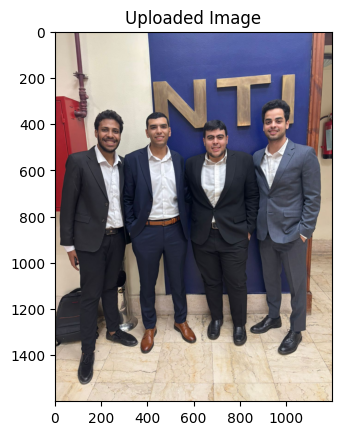

In [78]:
filename = "/content/faces.jpeg"

# Load and display the image
faceimage = io.imread(filename)
plt.imshow(faceimage)
plt.title("Uploaded Image")
plt.show()

If the image exceeds the maximum size of **4096 x 4096** pixels, it will be resized to fit within this limit:


In [79]:
# Resize if necessary
if faceimage.shape[0] > 4096 or faceimage.shape[1] > 4096:
    faceimage = rescale(faceimage, 0.5, mode="constant")
    io.imsave(filename, (faceimage * 255).astype(np.uint8))  # Save resized image
    print("Image resized and saved.")

## Adding Faces to the Collection

In this section, face detection is performed on the uploaded image. Any detected faces are added to the `collection` along with their corresponding embeddings. This process uses OpenCV's Haar Cascade classifier for face detection and the `face_recognition` library for extracting facial embeddings.


In [80]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
image = cv2.imread(filename)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Add faces to the collection with embeddings
for (x, y, w, h) in faces:
    face = image[y:y + h, x:x + w]
    face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face_embedding = face_recognition.face_encodings(face_rgb)
    if face_embedding:
        collection.append((face, face_embedding[0]))
        print(f"Face added to collection at location: x={x}, y={y}, w={w}, h={h}")


Face added to collection at location: x=878, y=339, w=133, h=133
Face added to collection at location: x=391, y=371, w=115, h=115
Face added to collection at location: x=171, y=379, w=131, h=131
Face added to collection at location: x=633, y=414, w=120, h=120


## Visualizing Bounding Boxes

This section visualizes the detected faces by drawing bounding boxes around them using OpenCV's `cv2.rectangle` function. The bounding boxes are overlaid on the original image for visual confirmation.


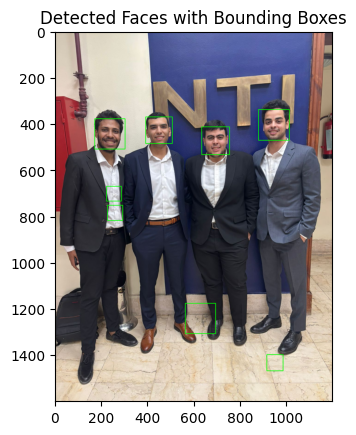

In [81]:
for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Faces with Bounding Boxes")
plt.show()

## Listing Faces in the Collection

After the faces have been added to the collection, you can display each face stored in the collection. The code uses `matplotlib` to show each face image individually:


Number of faces in collection: 4


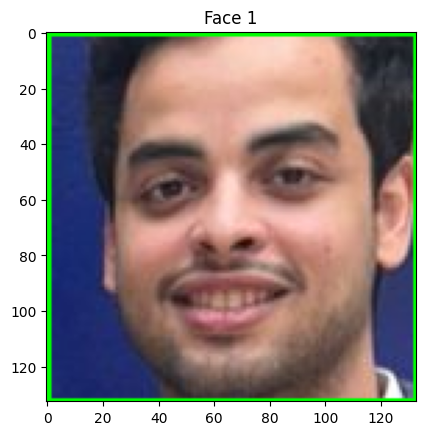

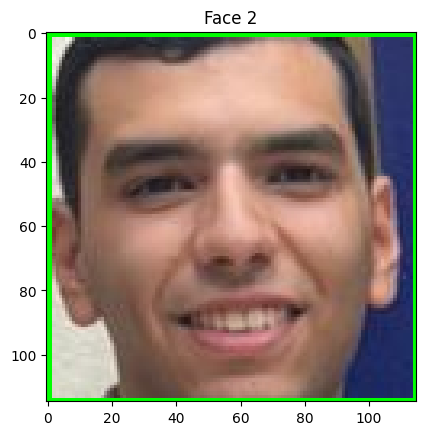

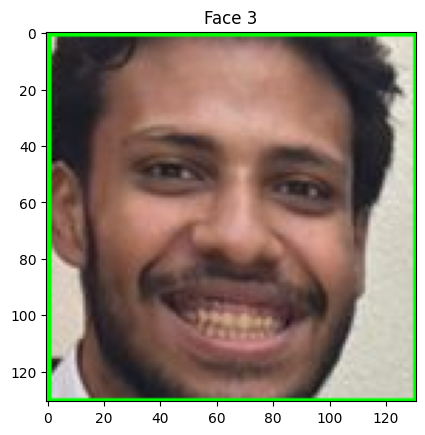

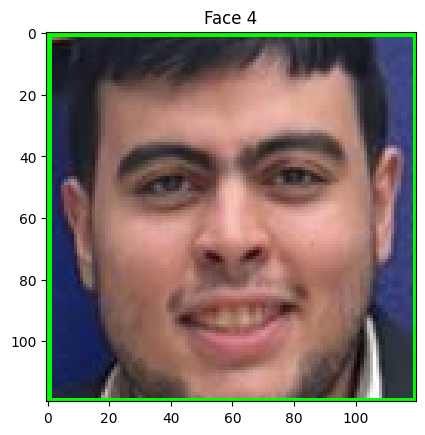

In [82]:
print(f"Number of faces in collection: {len(collection)}")
for i, (face, _) in enumerate(collection):
    plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
    plt.title(f"Face {i + 1}")
    plt.show()

## Finding and Matching Faces in the Collection with a Target Image

In this section, faces from the collection are matched against faces detected in a new target image (e.g., *WhatsApp Image 2024-11-20 at 9.17.19 PM.jpeg*). The function `find_best_match_for_each_face` compares each face in the collection with faces found in the target image. It returns the best match based on the similarity score of facial embeddings.


In [83]:
def find_best_match_for_each_face(collection, target_faces, targetimage):
    """
    Finds the best matching face for each collection face in the target image.

    Args:
    - collection: List of (face_image, face_embedding) tuples.
    - target_faces: List of bounding boxes for detected faces in the target image.
    - targetimage: The target image containing the detected faces.

    Returns:
    - matches: A list of tuples containing the best matching face location and similarity score.
    """
    matches = []
    for collection_index, (collection_face, collection_embedding) in enumerate(collection):
        best_similarity = 0
        best_match_location = None

        # Iterate through all faces in the target image
        for (x, y, w, h) in target_faces:
            target_face = targetimage[y:y + h, x:x + w]
            similarity = find_best_match(target_face, [(collection_face, collection_embedding)])[1]  # Find similarity with each collection face

            # Keep track of the best match for the current collection face
            if similarity > best_similarity:
                best_similarity = similarity
                best_match_location = (x, y, w, h)

        if best_match_location:
            matches.append((best_match_location, best_similarity, collection_index))

    return matches

## Drawing Bounding Boxes Around the Best Matches

Once the best match for each face in the collection is found, bounding boxes are drawn around the faces in the target image to highlight the matches.


Match found for face at (x=1703, y=1037) with collection face 0 (similarity=0.67)
Match found for face at (x=544, y=1045) with collection face 1 (similarity=0.64)
Match found for face at (x=1075, y=1197) with collection face 2 (similarity=0.72)
Match found for face at (x=1385, y=1269) with collection face 3 (similarity=0.67)


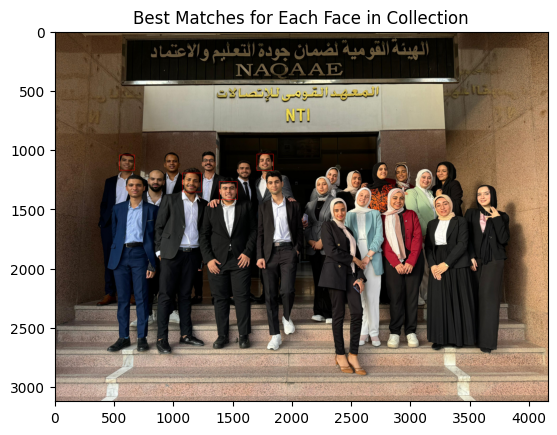

In [84]:
# Load target image
targetfilename = "/content/target.jpeg"
targetimage = cv2.imread(targetfilename)
targetgray = cv2.cvtColor(targetimage, cv2.COLOR_BGR2GRAY)

# Detect faces in the target image
target_faces = face_cascade.detectMultiScale(targetgray, scaleFactor=1.1, minNeighbors=5, minSize=(50, 50))

# Find the best match for each face in the collection
matches = find_best_match_for_each_face(collection, target_faces, targetimage)

# Draw bounding boxes and display best matches
for (x, y, w, h), similarity, collection_index in matches:
    cv2.rectangle(targetimage, (x, y), (x + w, y + h), (0, 0, 255), 2)
    print(f"Match found for face at (x={x}, y={y}) with collection face {collection_index} (similarity={similarity:.2f})")

# Show the result
plt.imshow(cv2.cvtColor(targetimage, cv2.COLOR_BGR2RGB))
plt.title("Best Matches for Each Face in Collection")
plt.show()

## Clearing the Collection

Finally, after the face detection and matching process is complete, the collection is cleared using the `clear()` method to free up memory.


In [85]:
# Task 8: Clearing the collection
collection.clear()
print("Face collection cleared.")

Face collection cleared.
